<div style="margin-bottom: 32px;">
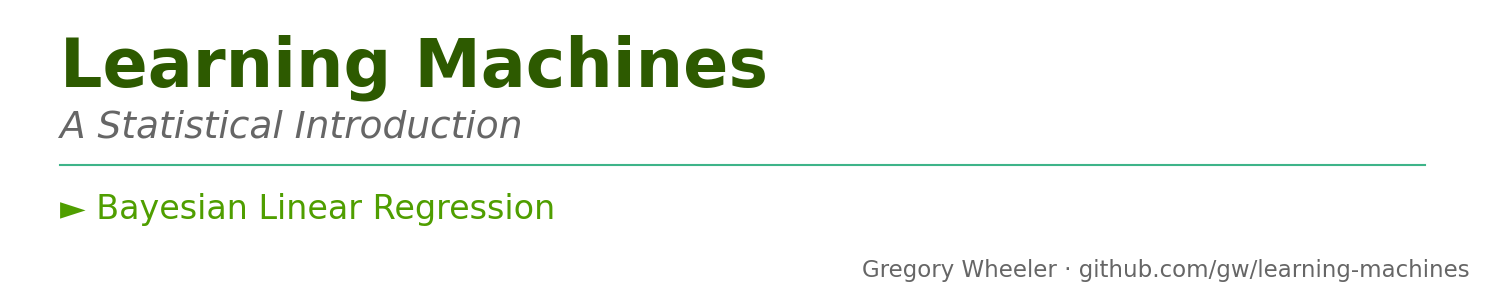
</div>


# Bayesian Linear Regression

**Note**: This notebook covers optional enrichment material for readers with interest in Bayesian methods. It requires PyMC, which is not part of the core dependencies.

---

Frequentist regression gives us point estimates: a single "best" value for each coefficient. Bayesian regression gives us **distributions**—complete descriptions of our uncertainty about each parameter. This notebook makes the Bayesian approach concrete: we specify priors, watch them update to posteriors as data arrives, and see how prior beliefs and data jointly determine our conclusions.

**What computation adds**: Bayesian inference involves integrals that rarely have closed forms. MCMC sampling lets us approximate posteriors for any model. Visualization of prior→posterior transformation shows exactly how data changes beliefs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd()))

# Import our custom theme
import mlone_theme as mt
plt.style.use('mlone_style.mplstyle')
mt.set_notebook_mode()

np.random.seed(42)

In [ ]:
# Check for PyMC installation
try:
    import pymc as pm
    import arviz as az
    print(f"PyMC version: {pm.__version__}")
    PYMC_AVAILABLE = True
except ImportError:
    print("PyMC not installed. Install with: pip install pymc arviz")
    print("This notebook will show analytical solutions but skip MCMC sections.")
    PYMC_AVAILABLE = False

---
## 1. Frequentist vs. Bayesian: Two Philosophies

| Aspect | Frequentist | Bayesian |
|--------|-------------|----------|
| Parameters | Fixed but unknown | Random variables with distributions |
| Data | Random (from repeated sampling) | Fixed (what we observed) |
| Inference | Point estimates + confidence intervals | Posterior distributions |
| Prior knowledge | Not formally incorporated | Encoded in prior distributions |

**Bayes' theorem** connects prior beliefs to posterior beliefs:

$$P(\theta | \text{data}) = \frac{P(\text{data} | \theta) \cdot P(\theta)}{P(\text{data})}$$

$$\text{Posterior} \propto \text{Likelihood} \times \text{Prior}$$

---
## 2. A Simple Example: Estimating a Mean

Before tackling regression, let's see how Bayesian updating works for a simple problem: estimating the mean of a normal distribution.

**Setup:**
- Data: $x_i \sim N(\mu, \sigma^2)$ with known $\sigma^2 = 1$
- Prior: $\mu \sim N(\mu_0, \sigma_0^2)$
- Posterior: $\mu | \text{data} \sim N(\mu_n, \sigma_n^2)$

The posterior has a closed form (conjugate prior):

$$\mu_n = \frac{\sigma^2 \mu_0 + n \sigma_0^2 \bar{x}}{\sigma^2 + n \sigma_0^2}, \quad \sigma_n^2 = \frac{\sigma^2 \sigma_0^2}{\sigma^2 + n \sigma_0^2}$$

In [ ]:
def bayesian_normal_update(data, prior_mean, prior_var, likelihood_var):
    """
    Analytical Bayesian update for normal mean with known variance.
    
    Returns posterior mean and variance.
    """
    n = len(data)
    data_mean = np.mean(data) if n > 0 else 0
    
    # Posterior parameters
    posterior_var = 1 / (1/prior_var + n/likelihood_var)
    posterior_mean = posterior_var * (prior_mean/prior_var + n*data_mean/likelihood_var)
    
    return posterior_mean, posterior_var

In [ ]:
# True parameters
true_mean = 2.5
known_var = 1.0

# Prior: centered at 0, fairly uncertain
prior_mean = 0.0
prior_var = 4.0

# Generate data sequentially
np.random.seed(42)
all_data = np.random.normal(true_mean, np.sqrt(known_var), 50)

# Visualize prior → posterior updating
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

sample_sizes = [0, 1, 3, 10, 25, 50]
x_range = np.linspace(-4, 6, 200)

for ax, n in zip(axes, sample_sizes):
    data = all_data[:n] if n > 0 else []
    
    post_mean, post_var = bayesian_normal_update(data, prior_mean, prior_var, known_var)
    post_std = np.sqrt(post_var)
    
    # Prior
    prior_pdf = stats.norm.pdf(x_range, prior_mean, np.sqrt(prior_var))
    ax.fill_between(x_range, prior_pdf, alpha=0.3, color=mt.GRAY, label='Prior')
    
    # Posterior
    post_pdf = stats.norm.pdf(x_range, post_mean, post_std)
    ax.fill_between(x_range, post_pdf, alpha=0.5, color=mt.GREEN, label='Posterior')
    ax.plot(x_range, post_pdf, color=mt.GREEN, linewidth=2)
    
    # True value
    ax.axvline(true_mean, color=mt.RED, linestyle='--', linewidth=2, label=f'True μ = {true_mean}')
    
    # Data points
    if n > 0:
        ax.scatter(data, np.zeros(n) - 0.02, color=mt.BLUE, s=30, alpha=0.7, zorder=5)
    
    ax.set_xlabel('μ')
    ax.set_ylabel('Density')
    ax.set_title(f'n = {n} observations\nPosterior: {post_mean:.2f} ± {1.96*post_std:.2f}',
                 fontweight='bold')
    ax.set_xlim(-4, 6)
    ax.set_ylim(-0.05, 1.2)
    
    if n == 0:
        ax.legend(loc='upper right', fontsize=9)
    
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Key observations:**
- With **no data** (n=0), the posterior equals the prior
- As **data accumulates**, the posterior concentrates around the true value
- The posterior is a **compromise** between prior and data
- With enough data, the prior becomes irrelevant (the data dominates)

---
## 3. Bayesian Linear Regression: The Model

Now let's apply the Bayesian approach to linear regression.

**Model:**
$$y = \beta_0 + \beta_1 x + \epsilon, \quad \epsilon \sim N(0, \sigma^2)$$

**Priors:**
- $\beta_0 \sim N(0, \tau_0^2)$
- $\beta_1 \sim N(0, \tau_1^2)$
- $\sigma \sim \text{HalfNormal}(s)$ (must be positive)

**Goal:** Compute the posterior $P(\beta_0, \beta_1, \sigma | \text{data})$

In [ ]:
# Generate regression data
np.random.seed(42)

true_beta0 = 1.0
true_beta1 = 2.0
true_sigma = 0.5

n_samples = 30
X = np.random.uniform(0, 3, n_samples)
y = true_beta0 + true_beta1 * X + np.random.normal(0, true_sigma, n_samples)

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(X, y, c=mt.GREEN, s=60, alpha=0.7, edgecolors='white', linewidths=1, 
           label='Observations')

x_line = np.linspace(0, 3, 100)
ax.plot(x_line, true_beta0 + true_beta1 * x_line, c=mt.GRAY, linestyle='--', 
        linewidth=2, label=f'True line: y = {true_beta0} + {true_beta1}x')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Regression Data', fontweight='bold', loc='left')
ax.legend()
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 4. Analytical Solution (Conjugate Prior)

For linear regression with Gaussian priors on coefficients and known variance, the posterior is also Gaussian. Let's compute it analytically first.

In [ ]:
def bayesian_linear_regression_analytical(X, y, prior_mean, prior_cov, noise_var):
    """
    Analytical Bayesian linear regression with Gaussian prior.
    
    Parameters:
        X: Design matrix (n, p) including intercept column
        y: Target values (n,)
        prior_mean: Prior mean for coefficients (p,)
        prior_cov: Prior covariance matrix (p, p)
        noise_var: Known noise variance σ²
    
    Returns:
        posterior_mean: (p,)
        posterior_cov: (p, p)
    """
    prior_precision = np.linalg.inv(prior_cov)
    
    # Posterior precision and covariance
    posterior_precision = prior_precision + (1/noise_var) * X.T @ X
    posterior_cov = np.linalg.inv(posterior_precision)
    
    # Posterior mean
    posterior_mean = posterior_cov @ (prior_precision @ prior_mean + (1/noise_var) * X.T @ y)
    
    return posterior_mean, posterior_cov

In [ ]:
# Create design matrix with intercept
X_design = np.column_stack([np.ones(n_samples), X])

# Prior: fairly vague
prior_mean = np.array([0.0, 0.0])
prior_cov = np.array([[10.0, 0.0],
                      [0.0, 10.0]])

# Assume known noise variance (for analytical solution)
noise_var = true_sigma**2

# Compute posterior
post_mean, post_cov = bayesian_linear_regression_analytical(
    X_design, y, prior_mean, prior_cov, noise_var
)

print("Analytical Bayesian Regression Results:")
print(f"  Posterior mean β₀: {post_mean[0]:.3f} (true: {true_beta0})")
print(f"  Posterior mean β₁: {post_mean[1]:.3f} (true: {true_beta1})")
print(f"  Posterior std β₀:  {np.sqrt(post_cov[0,0]):.3f}")
print(f"  Posterior std β₁:  {np.sqrt(post_cov[1,1]):.3f}")

# Compare to OLS
ols_beta = np.linalg.lstsq(X_design, y, rcond=None)[0]
print(f"\nOLS estimates:")
print(f"  β₀: {ols_beta[0]:.3f}")
print(f"  β₁: {ols_beta[1]:.3f}")

---
## 5. Visualizing the Posterior Distribution

Unlike OLS which gives point estimates, Bayesian regression gives a **joint distribution** over all parameters.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Marginal posterior for β₀
ax = axes[0]
b0_range = np.linspace(post_mean[0] - 3*np.sqrt(post_cov[0,0]),
                       post_mean[0] + 3*np.sqrt(post_cov[0,0]), 100)
b0_pdf = stats.norm.pdf(b0_range, post_mean[0], np.sqrt(post_cov[0,0]))
ax.fill_between(b0_range, b0_pdf, alpha=0.5, color=mt.GREEN)
ax.plot(b0_range, b0_pdf, color=mt.GREEN, linewidth=2)
ax.axvline(true_beta0, color=mt.RED, linestyle='--', linewidth=2, label=f'True β₀ = {true_beta0}')
ax.axvline(post_mean[0], color=mt.BLUE, linestyle='-', linewidth=2, label=f'Posterior mean')
ax.set_xlabel('β₀ (intercept)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Intercept', fontweight='bold', loc='left')
ax.legend(fontsize=9)
mt.apply_economist_style(ax)

# Marginal posterior for β₁
ax = axes[1]
b1_range = np.linspace(post_mean[1] - 3*np.sqrt(post_cov[1,1]),
                       post_mean[1] + 3*np.sqrt(post_cov[1,1]), 100)
b1_pdf = stats.norm.pdf(b1_range, post_mean[1], np.sqrt(post_cov[1,1]))
ax.fill_between(b1_range, b1_pdf, alpha=0.5, color=mt.GREEN)
ax.plot(b1_range, b1_pdf, color=mt.GREEN, linewidth=2)
ax.axvline(true_beta1, color=mt.RED, linestyle='--', linewidth=2, label=f'True β₁ = {true_beta1}')
ax.axvline(post_mean[1], color=mt.BLUE, linestyle='-', linewidth=2, label=f'Posterior mean')
ax.set_xlabel('β₁ (slope)')
ax.set_ylabel('Density')
ax.set_title('Posterior: Slope', fontweight='bold', loc='left')
ax.legend(fontsize=9)
mt.apply_economist_style(ax)

# Joint posterior contours
ax = axes[2]
b0_grid = np.linspace(post_mean[0] - 3*np.sqrt(post_cov[0,0]),
                      post_mean[0] + 3*np.sqrt(post_cov[0,0]), 100)
b1_grid = np.linspace(post_mean[1] - 3*np.sqrt(post_cov[1,1]),
                      post_mean[1] + 3*np.sqrt(post_cov[1,1]), 100)
B0, B1 = np.meshgrid(b0_grid, b1_grid)
pos = np.dstack((B0, B1))
rv = stats.multivariate_normal(post_mean, post_cov)
Z = rv.pdf(pos)

ax.contourf(B0, B1, Z, levels=20, cmap='Greens', alpha=0.7)
ax.contour(B0, B1, Z, levels=5, colors='darkgreen', linewidths=0.5)
ax.scatter(true_beta0, true_beta1, c=mt.RED, s=100, marker='*', 
           zorder=5, label='True values', edgecolors='white', linewidths=1)
ax.scatter(post_mean[0], post_mean[1], c=mt.BLUE, s=100, marker='o',
           zorder=5, label='Posterior mean', edgecolors='white', linewidths=1)
ax.set_xlabel('β₀')
ax.set_ylabel('β₁')
ax.set_title('Joint Posterior', fontweight='bold', loc='left')
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

---
## 6. Posterior Predictive Distribution

For a new input $x^*$, the **posterior predictive distribution** accounts for:
1. Uncertainty about the parameters (posterior variance)
2. Observation noise (σ²)

$$p(y^* | x^*, \text{data}) = \int p(y^* | x^*, \theta) p(\theta | \text{data}) d\theta$$

This gives us **credible intervals** for predictions.

In [ ]:
def posterior_predictive(x_new, post_mean, post_cov, noise_var):
    """
    Compute posterior predictive mean and variance for new inputs.
    
    x_new: New input points (m,)
    Returns: predictive mean (m,), predictive variance (m,)
    """
    X_new = np.column_stack([np.ones(len(x_new)), x_new])
    
    # Predictive mean: E[y*] = X* @ posterior_mean
    pred_mean = X_new @ post_mean
    
    # Predictive variance: Var[y*] = X* @ posterior_cov @ X*.T + noise_var
    pred_var = np.sum(X_new @ post_cov * X_new, axis=1) + noise_var
    
    return pred_mean, pred_var

In [ ]:
# Compute predictions
x_plot = np.linspace(-0.5, 3.5, 100)
pred_mean, pred_var = posterior_predictive(x_plot, post_mean, post_cov, noise_var)
pred_std = np.sqrt(pred_var)

fig, ax = plt.subplots(figsize=(10, 6))

# 95% credible interval
ax.fill_between(x_plot, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std,
                alpha=0.3, color=mt.GREEN, label='95% credible interval')

# Posterior mean prediction
ax.plot(x_plot, pred_mean, c=mt.GREEN, linewidth=2.5, label='Posterior mean')

# True line
ax.plot(x_plot, true_beta0 + true_beta1 * x_plot, c=mt.GRAY, linestyle='--',
        linewidth=2, label='True line')

# Data
ax.scatter(X, y, c=mt.BLUE, s=60, alpha=0.7, edgecolors='white', linewidths=1,
           label='Observations', zorder=5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Bayesian Regression: Posterior Predictive Distribution', 
             fontweight='bold', loc='left')
ax.legend(loc='upper left')
ax.set_xlim(-0.5, 3.5)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Note**: The credible interval is **wider** away from the data center—where we have less information, we're more uncertain. This is a natural consequence of the Bayesian approach.

---
## 7. Sampling from the Posterior

We can draw **regression lines** from the posterior to visualize uncertainty.

In [ ]:
# Sample coefficients from posterior
n_samples_draw = 100
beta_samples = np.random.multivariate_normal(post_mean, post_cov, n_samples_draw)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Posterior samples in coefficient space
ax = axes[0]
ax.scatter(beta_samples[:, 0], beta_samples[:, 1], c=mt.GREEN, s=30, alpha=0.5,
           edgecolors='none', label='Posterior samples')
ax.scatter(true_beta0, true_beta1, c=mt.RED, s=150, marker='*',
           zorder=5, label='True values', edgecolors='white', linewidths=1)
ax.scatter(post_mean[0], post_mean[1], c=mt.BLUE, s=100, marker='o',
           zorder=5, label='Posterior mean', edgecolors='white', linewidths=1)

# Add posterior ellipse
from matplotlib.patches import Ellipse
eigenvalues, eigenvectors = np.linalg.eigh(post_cov)
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
for n_std in [1, 2]:
    ell = Ellipse(xy=post_mean, width=2*n_std*np.sqrt(eigenvalues[0]),
                  height=2*n_std*np.sqrt(eigenvalues[1]), angle=angle,
                  facecolor='none', edgecolor=mt.GREEN, linewidth=1.5,
                  linestyle='--' if n_std == 2 else '-')
    ax.add_patch(ell)

ax.set_xlabel('β₀')
ax.set_ylabel('β₁')
ax.set_title('Posterior Samples in Coefficient Space', fontweight='bold', loc='left')
ax.legend(loc='upper right')
ax.set_aspect('equal', adjustable='datalim')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
ax.grid(True, alpha=0.3)

# Right: Corresponding regression lines
ax = axes[1]
for i in range(min(50, n_samples_draw)):
    y_sample = beta_samples[i, 0] + beta_samples[i, 1] * x_plot
    ax.plot(x_plot, y_sample, c=mt.GREEN, alpha=0.15, linewidth=1)

# Posterior mean
ax.plot(x_plot, pred_mean, c=mt.GREEN, linewidth=2.5, label='Posterior mean')

# True line
ax.plot(x_plot, true_beta0 + true_beta1 * x_plot, c=mt.RED, linestyle='--',
        linewidth=2, label='True line')

# Data
ax.scatter(X, y, c=mt.BLUE, s=60, alpha=0.7, edgecolors='white', linewidths=1,
           zorder=5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Posterior Sample Regression Lines', fontweight='bold', loc='left')
ax.legend(loc='upper left')
ax.set_xlim(-0.5, 3.5)
mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

---
## 8. The Effect of the Prior

Let's see how different priors affect the posterior.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

priors = [
    ("Vague prior", np.array([0, 0]), np.array([[100, 0], [0, 100]])),
    ("Informative (correct)", np.array([1, 2]), np.array([[0.5, 0], [0, 0.5]])),
    ("Informative (wrong)", np.array([5, -1]), np.array([[0.5, 0], [0, 0.5]])),
]

for ax, (title, p_mean, p_cov) in zip(axes, priors):
    pm, pc = bayesian_linear_regression_analytical(X_design, y, p_mean, p_cov, noise_var)
    pred_m, pred_v = posterior_predictive(x_plot, pm, pc, noise_var)
    pred_s = np.sqrt(pred_v)
    
    # Credible interval
    ax.fill_between(x_plot, pred_m - 1.96*pred_s, pred_m + 1.96*pred_s,
                    alpha=0.3, color=mt.GREEN)
    ax.plot(x_plot, pred_m, c=mt.GREEN, linewidth=2.5, label='Posterior mean')
    
    # True and data
    ax.plot(x_plot, true_beta0 + true_beta1 * x_plot, c=mt.GRAY, linestyle='--',
            linewidth=2, label='True line')
    ax.scatter(X, y, c=mt.BLUE, s=40, alpha=0.7, edgecolors='white', linewidths=0.5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title}\nβ₀={pm[0]:.2f}, β₁={pm[1]:.2f}', fontweight='bold')
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-2, 10)
    if ax == axes[0]:
        ax.legend(loc='upper left', fontsize=9)
    mt.apply_economist_style(ax)

plt.tight_layout()
plt.show()

**Observations:**
- **Vague prior**: Posterior dominated by data (similar to OLS)
- **Correct informative prior**: Tighter credible intervals, faster convergence
- **Wrong informative prior**: Posterior is pulled toward wrong values, but still improves with more data

---
## 9. Connection to Ridge Regression

A Gaussian prior on coefficients is equivalent to **L2 regularization** (Ridge regression)!

Ridge minimizes:
$$\sum_i (y_i - \mathbf{x}_i^T\boldsymbol{\beta})^2 + \lambda \|\boldsymbol{\beta}\|^2$$

This is the **MAP estimate** (maximum a posteriori) under a Gaussian prior with variance $\sigma^2/\lambda$.

In [ ]:
from sklearn.linear_model import Ridge

# Compare Ridge to Bayesian posterior mean
lambda_values = [0.01, 0.1, 1.0, 10.0]

print("Ridge vs Bayesian MAP comparison:")
print(f"{'λ':>8} {'Ridge β₀':>12} {'Ridge β₁':>12} {'Bayes β₀':>12} {'Bayes β₁':>12}")
print("-" * 60)

for lam in lambda_values:
    # Ridge regression
    ridge = Ridge(alpha=lam, fit_intercept=True)
    ridge.fit(X.reshape(-1, 1), y)
    ridge_b0, ridge_b1 = ridge.intercept_, ridge.coef_[0]
    
    # Bayesian with corresponding prior variance
    prior_var = noise_var / lam
    p_cov = np.array([[100, 0], [0, prior_var]])  # Don't regularize intercept much
    pm, _ = bayesian_linear_regression_analytical(X_design, y, np.array([0, 0]), p_cov, noise_var)
    
    print(f"{lam:>8.2f} {ridge_b0:>12.4f} {ridge_b1:>12.4f} {pm[0]:>12.4f} {pm[1]:>12.4f}")

---
## 10. MCMC with PyMC (Optional)

For models without closed-form posteriors, we use **Markov Chain Monte Carlo (MCMC)** sampling. PyMC uses **NUTS** (No-U-Turn Sampler) by default—a sophisticated variant of Hamiltonian Monte Carlo that adapts automatically. Section 11 explains why this matters.

In [ ]:
if PYMC_AVAILABLE:
    # Build PyMC model
    with pm.Model() as regression_model:
        # Priors
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta1 = pm.Normal('beta1', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=2)
        
        # Linear model
        mu = beta0 + beta1 * X
        
        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
        # Sample from posterior using NUTS (No-U-Turn Sampler)
        # NUTS is an adaptive HMC algorithm—PyMC's default and recommended sampler
        trace = pm.sample(2000, tune=1000, cores=1, random_seed=42,
                          progressbar=True, return_inferencedata=True)
    
    # Confirm which sampler was used
    print(f"Sampler: {trace.sample_stats.sampling_method.values[0]}")
    print("\nPyMC Posterior Summary:")
    print(az.summary(trace, var_names=['beta0', 'beta1', 'sigma']))
else:
    print("PyMC not available. Skipping MCMC section.")
    print("Install with: pip install pymc arviz")

In [ ]:
if PYMC_AVAILABLE:
    # Visualize posterior distributions
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    for ax, var, true_val, label in zip(
        axes, 
        ['beta0', 'beta1', 'sigma'],
        [true_beta0, true_beta1, true_sigma],
        ['β₀ (intercept)', 'β₁ (slope)', 'σ (noise)']
    ):
        samples = trace.posterior[var].values.flatten()
        
        ax.hist(samples, bins=50, density=True, alpha=0.7, color=mt.GREEN,
                edgecolor='white', linewidth=0.5)
        ax.axvline(true_val, color=mt.RED, linestyle='--', linewidth=2,
                   label=f'True = {true_val}')
        ax.axvline(samples.mean(), color=mt.BLUE, linestyle='-', linewidth=2,
                   label=f'Mean = {samples.mean():.3f}')
        
        # 95% credible interval
        ci_low, ci_high = np.percentile(samples, [2.5, 97.5])
        ax.axvspan(ci_low, ci_high, alpha=0.2, color=mt.GREEN)
        
        ax.set_xlabel(label)
        ax.set_ylabel('Density')
        ax.set_title(f'Posterior: {label}', fontweight='bold', loc='left')
        ax.legend(fontsize=9)
        mt.apply_economist_style(ax)
    
    plt.tight_layout()
    plt.show()

In [ ]:
if PYMC_AVAILABLE:
    # Posterior predictive with MCMC samples
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Draw regression lines from posterior samples
    b0_samples = trace.posterior['beta0'].values.flatten()
    b1_samples = trace.posterior['beta1'].values.flatten()
    
    for i in range(0, len(b0_samples), 50):  # Every 50th sample
        y_line = b0_samples[i] + b1_samples[i] * x_plot
        ax.plot(x_plot, y_line, c=mt.GREEN, alpha=0.05, linewidth=1)
    
    # Posterior mean
    y_mean = b0_samples.mean() + b1_samples.mean() * x_plot
    ax.plot(x_plot, y_mean, c=mt.GREEN, linewidth=2.5, label='Posterior mean')
    
    # True line
    ax.plot(x_plot, true_beta0 + true_beta1 * x_plot, c=mt.GRAY, linestyle='--',
            linewidth=2, label='True line')
    
    # Data
    ax.scatter(X, y, c=mt.BLUE, s=60, alpha=0.7, edgecolors='white', linewidths=1,
               zorder=5, label='Observations')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('MCMC Posterior Predictive', fontweight='bold', loc='left')
    ax.legend(loc='upper left')
    ax.set_xlim(-0.5, 3.5)
    mt.apply_economist_style(ax)
    
    plt.tight_layout()
    plt.show()

---
## 11. Why HMC? Efficient Exploration

The `pm.sample()` call above uses **Hamiltonian Monte Carlo (HMC)**—specifically, the **NUTS** (No-U-Turn Sampler) variant. This is far more efficient than the "vanilla" MCMC methods (like Metropolis-Hastings) you might encounter in textbooks. Understanding why matters for practical Bayesian inference.

### The Problem with Random-Walk MCMC

Classic Metropolis-Hastings explores the posterior by proposing **random steps** from the current position. In high dimensions, most random directions lead to low-probability regions, so:
- Most proposals are rejected
- The chain takes tiny steps to maintain reasonable acceptance
- Exploration is slow—samples are highly correlated

### HMC: Using Gradients to Guide Exploration

HMC treats the negative log-posterior as a "potential energy" surface and simulates a particle rolling on it. The key insight: **gradients tell us which way is uphill**, so we can propose moves that stay in high-probability regions.

The physics analogy:
1. Give the particle random momentum (velocity)
2. Simulate Hamiltonian dynamics—the particle rolls, trading potential and kinetic energy
3. The endpoint becomes the proposal (accepted with high probability because energy is conserved)

**Result**: Large moves through parameter space with high acceptance rates.

### NUTS: Adaptive HMC

HMC requires tuning the step size and number of steps. **NUTS** (the PyMC default) adapts automatically:
- Simulates until the trajectory would "turn around" (the No-U-Turn criterion)
- No manual tuning of trajectory length required

This is why PyMC "just works" for most models—NUTS handles the difficult tuning automatically.


In [ ]:
if PYMC_AVAILABLE:
    # Diagnostics: trace plots show how well the sampler explored
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    
    for row, var in enumerate(['beta0', 'beta1', 'sigma']):
        samples = trace.posterior[var].values.flatten()
        
        # Left: trace plot (should look like "fuzzy caterpillar")
        ax = axes[row, 0]
        ax.plot(samples[:500], color=mt.GREEN, alpha=0.7, linewidth=0.5)
        ax.set_ylabel(var)
        ax.set_title(f'Trace: {var}' if row == 0 else '', fontweight='bold', loc='left')
        if row == 2:
            ax.set_xlabel('Sample')
        mt.apply_economist_style(ax)
        
        # Right: autocorrelation (should decay quickly for HMC)
        ax = axes[row, 1]
        max_lag = 50
        autocorr = [np.corrcoef(samples[:-lag], samples[lag:])[0,1] 
                    for lag in range(1, max_lag)]
        ax.bar(range(1, max_lag), autocorr, color=mt.GREEN, alpha=0.7)
        ax.axhline(0, color='black', linewidth=0.5)
        ax.set_ylabel('Autocorrelation')
        ax.set_title('Autocorrelation' if row == 0 else '', fontweight='bold', loc='left')
        if row == 2:
            ax.set_xlabel('Lag')
        ax.set_ylim(-0.2, 1)
        mt.apply_economist_style(ax)
    
    plt.tight_layout()
    plt.show()
    
    # Effective sample size
    print("Effective Sample Size (ESS):")
    print("  (Higher is better; ideally close to actual sample count)")
    summary = az.summary(trace, var_names=['beta0', 'beta1', 'sigma'])
    for var in ['beta0', 'beta1', 'sigma']:
        ess = summary.loc[var, 'ess_bulk']
        print(f"  {var}: {ess:.0f} effective samples from {len(samples)} draws")

**Reading the diagnostics:**

- **Trace plots** (left): Should look like a "fuzzy caterpillar"—rapid mixing with no trends or stuck regions. HMC typically achieves this; random-walk Metropolis often shows slow wandering.

- **Autocorrelation** (right): Shows correlation between samples at different lags. HMC produces nearly independent samples (autocorrelation drops quickly); random-walk MCMC shows high autocorrelation for many lags.

- **Effective Sample Size (ESS)**: Estimates how many *independent* samples you have. With HMC/NUTS, ESS is often close to the actual number of draws. With random-walk MCMC, ESS can be 10-100× smaller.

### When HMC Struggles

HMC requires gradients, so it needs:
- Continuous parameters (discrete parameters need other methods)
- Differentiable log-probability (PyMC handles this automatically)

It can also struggle with:
- Highly correlated posteriors (reparameterization helps)
- Multi-modal posteriors (may get stuck in one mode)
- "Funnel" geometries common in hierarchical models

For this simple regression, NUTS works effortlessly. For complex models, diagnostics become essential.


---
## 12. Summary

**Bayesian vs. Frequentist:**

| Aspect | Frequentist (OLS) | Bayesian |
|--------|-------------------|----------|
| Output | Point estimates | Full posterior distributions |
| Uncertainty | Confidence intervals (frequentist interpretation) | Credible intervals (probability statements) |
| Prior knowledge | Not incorporated | Formally specified |
| Small samples | Can be unstable | Regularized by prior |

**Key concepts:**
- **Prior**: Our beliefs before seeing data
- **Likelihood**: How probable is the data given parameters?
- **Posterior**: Updated beliefs after seeing data
- **Posterior predictive**: Distribution over future observations

**Practical insights:**
- With vague priors and enough data, Bayesian and frequentist results converge
- Gaussian priors ↔ Ridge regularization
- MCMC enables Bayesian inference for complex models

**When to use Bayesian methods:**
- When you have meaningful prior information
- When you need uncertainty quantification
- When sample sizes are small
- For hierarchical/multilevel models

---
## 13. Exploration

Try modifying:
- **Sample size**: How does the posterior change with n = 5, 50, 500?
- **Prior strength**: What happens with very tight priors?
- **Model complexity**: Extend to polynomial regression with PyMC
- **Hierarchical models**: Add group-level variation with PyMC